In [2]:
import numpy as np
import binaryCorr
import astropy.io.fits as pyfits
import sys
import os
import stingray.pulse as STpulse
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from stingray.pulse.search import epoch_folding_search, z_n_search, phase_dispersion_search
plt.style.use('science')
plt.rcParams['text.usetex'] = True
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList, Lightcurve
from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis,create_gti_mask
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray.modeling.parameterestimation import PSDLogLikelihood
from scipy.optimize import curve_fit
#from sklearn.mixture import GaussianMixturet
from sklearn import mixture
from sklearn.cluster import KMeans
import scipy.stats
from stingray.pulse import fftfit
from numpy import *
from scipy import interpolate
import glob

In [3]:
def hxbary(input,output,orbitfile):
    header = pyfits.open(input)[1].header
    # if header['OBS_MODE'] != 'Pointing':
    #     print('The Pointing mode is required!')
    #     #os.sys.exit()
    ra = header['RA_OBJ']
    dec = header['DEC_OBJ']
    print(ra,dec)
    #os.system("hxbary  evtfile=%s  orbitfile=%s  ra=%lf  dec=%lf eph=2 clobber=yes"%(evt, orbitfile,  ra, dec))
    print("barycorr ra=%s dec=%s refframe=ICRS infile=%s outfile=%s orbitfiles=%s"%(ra,dec,input,output,orbitfile))
    #Ephemeris (1 for DE200,2 for DE405)"

In [4]:
def efold(time, cts, period, nbins = 16, dt = 1, cts_err = None):
    phase = STpulse.pulse_phase(time, 1./period)    
    phase_ind = phase // (1./nbins)
    mk = [phase_ind == j for j in range(nbins)]    
    #---
    bin_time = np.array([len(cts[mk[k]]) * dt for k in range(nbins)])
    #---    
    if cts_err is None:    
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.sqrt(bin_cts)

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time
    else:
        bin_cts = np.array([cts[mk[k]].sum() for k in range(nbins)])
        bin_cts_err = np.array([np.sqrt((cts_err[mk[k]]**2).sum()) for k in range(nbins)])

        bin_cts = bin_cts/bin_time
        bin_cts_err = bin_cts_err/bin_time  
    
    #---
    bin_phase = np.linspace(0, 1, nbins + 1)
    bin_phase = (bin_phase[1:] + bin_phase[:-1])/2.    
    return bin_phase, bin_cts, bin_cts_err#unit: cts/s

In [5]:
def efold_search(time, cts, prange, ref=0, cts_err = None, nbins = 16, dt = 1):
    def const(x, a):
        return a    
    time = time - ref
    chi2 = np.zeros(len(prange))
    for i, p in enumerate(prange):
#         print(i)
        bin_phase, bin_cts, bin_cts_err = efold(time, cts, p, nbins = nbins, dt = dt, cts_err = cts_err)
        #---
        popt, pcov = curve_fit(const, bin_phase, bin_cts, sigma = bin_cts_err, p0 = [bin_cts.mean()])
        model = popt[0]
        chi2[i] = (((model - bin_cts) / bin_cts_err)**2).sum()        
    #---------------------------
    return prange, chi2

In [6]:
# method 2: Z2, explain how to estimate the error; how to choose the Zorder, although it is useless for this work
# (http://adsabs.harvard.edu/abs/1983A%26A...128..245B)
def calc_phase(time, period, timestart=0):
    time=time-timestart
    phase = np.mod(time, period)*1.0/period
    return phase
def calc_z2(phase, Zorder, norm):
    z2 = STpulse.z_n(phase, n=Zorder, norm=norm)
    return z2
# method 3: phase-connection ??

In [7]:
path = "/Volumes/WD_BLACK/Data/4U1626m67/NuSTAR"
obsid = 90901318004
input = "%s/%s_out/nu%sA01_cl_bary.evt"%(path,obsid,obsid)
output= input
orbitfile = "%s/%s_out/nu%sA.attorb"%(path,obsid,obsid)
#print(infile)
mjdref = pyfits.open(input)[1].header['mjdrefi']+pyfits.open(input)[1].header['mjdreff']
#t = pyfits.open(infile)[1].data['time']
print(input)
print(mjdref)

/Volumes/WD_BLACK/Data/4U1626m67/NuSTAR/90901318004_out/nu90901318004A01_cl_bary.evt
55197.00076601852


In [8]:
#barycen:
hxbary(input,output,orbitfile)

40.918437 61.434377
barycorr ra=40.918437 dec=61.434377 refframe=ICRS infile=/Volumes/WD_BLACK/Data/4U1626m67/NuSTAR/90901318004_out/nu90901318004A01_cl_bary.evt outfile=/Volumes/WD_BLACK/Data/4U1626m67/NuSTAR/90901318004_out/nu90901318004A01_cl_bary.evt orbitfiles=/Volumes/WD_BLACK/Data/4U1626m67/NuSTAR/90901318004_out/nu90901318004A.attorb


In [9]:
#read event files
tstart=pyfits.open(input)[1].header['TSTART']
#t0 = pyfits.open(input)[1].data['TIME']+tstart
t = pyfits.open(output)[1].data['TIME']
gti = np.array(pyfits.open(output)[2].data.tolist())
#gti = pyfits.open(input)[2].data
#gti = [[row['START'], row['STOP']] for row in gti]
#t_binCor = binCor(t,mjdref)
#Tobs2Tpulsar = interpolate.interp1d(t, t_binCor, fill_value='extrapolate', kind='linear')
#gti_binCor = Tobs2Tpulsar(gti)
time=t

0.00030183970693459364
(133,)


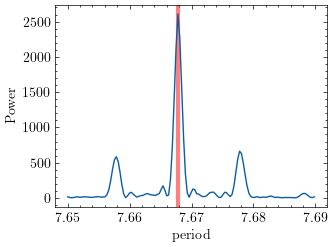

7.667808542709138 0.13041535849911645


In [12]:
#---------------------------------------------------
dp = 7.67**2/(time.max()-time.min())/2./3.
print(dp)
prange = np.arange(7.65, 7.69, dp) #explain why
print(prange.shape)
#Z2 method, an example for unbinned data
z2 = []
for p in prange:
     phase = calc_phase(time, p)
     z2.append(calc_z2(phase, 4, norm=1))

plt.errorbar(prange, z2)
period = prange[np.argmax(z2)]
plt.axvline(period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('period')
plt.ylabel('Power')
plt.show()
period = prange[np.argmax(z2)]
print(period,1/period)

# method 3: phase-connection ??

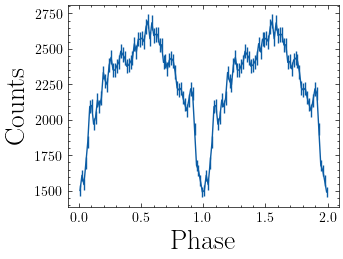

0.2874880611270296


In [20]:
#step 2: fold the lightcurve/events   
nbins = 64
#an example, binned data
# phase_bins, profile, profile_err= efold(lctime, cts, period, nbins = nbins, dt = timedel, cts_err = cts_err)

#an example, unbinned data
phase_bins, profile, profile_err = STpulse.fold_events(time-time[0]+0.35*period, 1./period, nbin = nbins)
plt.errorbar(np.hstack([phase_bins, phase_bins +1]), np.hstack([profile, profile]),\
             yerr = np.hstack([profile_err, profile_err]),fmt = '-')
plt.xlabel('Phase', fontsize = 20)
plt.ylabel('Counts', fontsize = 20)
plt.show()
rms=(profile.max()-profile.min())/(profile.max()+profile.min())
print(rms)
profile0=profile

In [21]:
phase_bins, profile

(array([0.0078125, 0.0234375, 0.0390625, 0.0546875, 0.0703125, 0.0859375,
        0.1015625, 0.1171875, 0.1328125, 0.1484375, 0.1640625, 0.1796875,
        0.1953125, 0.2109375, 0.2265625, 0.2421875, 0.2578125, 0.2734375,
        0.2890625, 0.3046875, 0.3203125, 0.3359375, 0.3515625, 0.3671875,
        0.3828125, 0.3984375, 0.4140625, 0.4296875, 0.4453125, 0.4609375,
        0.4765625, 0.4921875, 0.5078125, 0.5234375, 0.5390625, 0.5546875,
        0.5703125, 0.5859375, 0.6015625, 0.6171875, 0.6328125, 0.6484375,
        0.6640625, 0.6796875, 0.6953125, 0.7109375, 0.7265625, 0.7421875,
        0.7578125, 0.7734375, 0.7890625, 0.8046875, 0.8203125, 0.8359375,
        0.8515625, 0.8671875, 0.8828125, 0.8984375, 0.9140625, 0.9296875,
        0.9453125, 0.9609375, 0.9765625, 0.9921875]),
 array([1503., 1610., 1544., 1694., 1846., 2094., 2102., 1970., 2019.,
        2140., 2094., 2154., 2334., 2275., 2247., 2386., 2441., 2353.,
        2350., 2382., 2406., 2484., 2461., 2438., 2378., 2386., 

In [14]:
# phase_bins0, profile0, profile_err0= efold(time-0.55*period, cts, period, nbins = nbins, dt = timedel, cts_err = cts_err)
#phase_bins, profile, profile_err= efold(time-time[0], cts, period, nbins = nbins, dt = timedel, cts_err = cts_err)
phase_bins, profile, profile_err = STpulse.fold_events(time-time[0], 1./period, nbin = nbins)
dphi,dphie = transpose(fftfit(profile,template=profile0)[2:])
toa, toae = np.array(time[0])+dphi*(period), dphie*(period)

In [15]:
toa/86400+mjdref

60083.54341792225

In [16]:
toa

422197285.1244822

In [ ]:
phase_bins, profile, profile_err= efold(time-toa, cts, period, nbins = nbins, dt = timedel, cts_err = cts_err)
plt.errorbar(np.hstack([phase_bins, phase_bins +1]), np.hstack([profile, profile]),\
             yerr = np.hstack([profile_err, profile_err]),fmt = '-')
#plt.errorbar(np.hstack([phase_bins, phase_bins +1]), np.hstack([profile, profile]),drawstyle='steps-mid')
plt.xlabel('phase', color = 'green')
plt.ylabel('$\mathbf{Counts}$', fontsize = 20)
plt.show()

In [ ]:
time[0],422197285.1244822

In [ ]:
422197287.80807304

In [ ]:
422197658.889743